In [1]:
# The spelled-out intro to neural networks and backpropagation: building micrograd(https://youtu.be/VMj-3S1tku0?si=CnyW5BFfHFfUiDjF)


In [2]:
from graphviz import Digraph
import math

class Value:
    operator_precedence = {'+':1,'-':1,'*':2,'/':2, 'tenh':10}
    
    def _draw_self(self, dot, draw_operators = False):
        uid = str(id(self))
        dot.node(uid, label = '{%s | data %.4f | grad %.4f}' % (self.label, self.data, self.grad), shape='record')
        if draw_operators and self._op:
                dot.node(name = uid + self._op, label = self._op)
                dot.edge(uid + self._op, uid)#op->value
                for n in self._prev:
                    dot.edge(str(id(n)), uid + self._op )#prev->operator
                    n._draw_self(dot, draw_operators)
        else:
            for n in self._prev:
                    dot.edge(str(id(n)), str(id(self)))#prev->self
                    n._draw_self(dot, draw_operators)

    def draw(self, draw_operators = False):
        dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
        self._draw_self(dot, draw_operators)
        return dot

    def label_from(self, other, op):
        self_part = ''
        other_part = ''
        if self._op and Value.operator_precedence[self._op] < Value.operator_precedence[op]:
            self_part = f'({self.label})'
        else:
            self_part = self.label

        if other._op and Value.operator_precedence[other._op] < Value.operator_precedence[op]:
            other_part = f'({other.label})'
        else:
            other_part = other.label
        return f'{self_part}{op}{other_part}'
                
    def __init__(self, data, _prev=(), _op='', label = ''):
        self.data = data
        self._prev = set(_prev)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def backward(self):
        self._backward_rec(1.0)
    
    def _backward_rec(self, value):
        if value is not None:
            self.grad = value
        self._backward()
        for n in self._prev:
           n._backward_rec(None)

    def __repr__(self):
        return f'Value(data={self.data}, grad={self.grad}, label={self.label})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self,other), '+', self.label_from(other,'+') )
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other), '*', self.label_from(other,'*'))
        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        exp2X = math.exp(2.0*x)
        t = (exp2X-1)/(exp2X+1)
        out = Value(t, (self, ), 'tanh', f'tanh({self.label})')
        def _backward():
            self.grad  += (1 - t**2)*out.grad
        out._backward = _backward
        return out

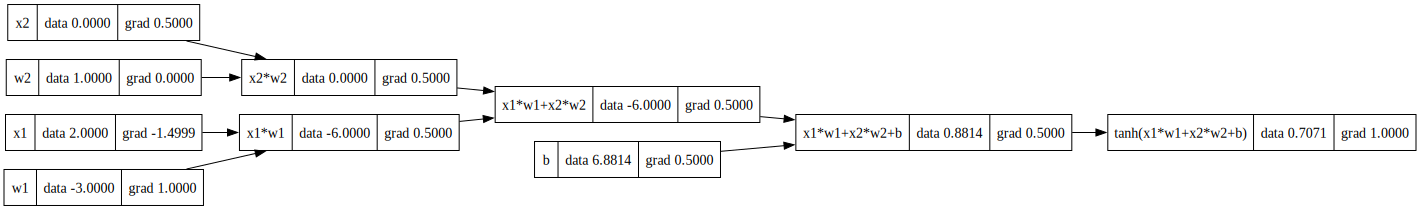

In [3]:
def test_0():
    x1 = Value(2.0, label = 'x1')
    x2 = Value(0.0, label = 'x2')
    w1 = Value(-3.0, label = 'w1')
    w2 = Value(1.0, label = 'w2')
    b = Value(6.8814, label = 'b')
    x1w1 = x1*w1
    x2w2 = x2*w2
    x1w1x2w2 = x1w1 + x2w2 
    pre_out = x1w1x2w2 + b
    out = (pre_out).tanh()

    out.grad = 1.0
    out._backward()
    pre_out._backward()
    x1w1x2w2._backward()
    x1w1._backward()
    x2w2._backward()
    b._backward()

    return out.draw()
test_0()

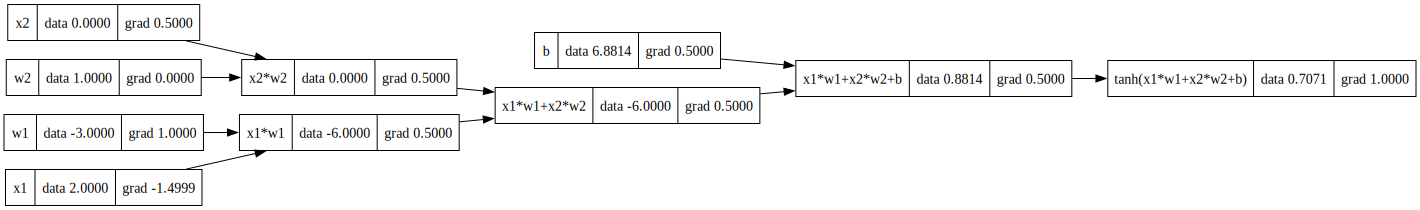

In [4]:
def test_1():
    x1 = Value(2.0, label = 'x1')
    x2 = Value(0.0, label = 'x2')
    w1 = Value(-3.0, label = 'w1')
    w2 = Value(1.0, label = 'w2')
    b = Value(6.8814, label = 'b')
    x1w1 = x1*w1
    x2w2 = x2*w2
    x1w1x2w2 = x1w1 + x2w2 
    pre_out = x1w1x2w2 + b
    out = (pre_out).tanh()

    out.backward()

    return out.draw()
test_1()